In [ ]:
#import the libriries
import math
import random
import matplotlib.pyplot as plt

In [ ]:
#visualise the TSP
def plotTSP(paths, points, num_iters=1):

    """
    paths: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the paths list
    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(min(x)*1.1, max(x)*1.1)
    plt.ylim(min(y)*1.1, max(y)*1.1)
    plt.show()

In [ ]:
class SimAnneal(object):
    def __init__(self, coords, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        self.coords = coords
        self.N = len(coords)
        self.T = math.sqrt(self.N) if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
        self.alpha = 0.995 if alpha == -1 else alpha
        self.stopping_temperature = 1e-8 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1

        self.nodes = [i for i in range(self.N)]

        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []

    def initial_solution(self):
        """
        Greedy algorithm to get an initial solution (closest-neighbour).
        """
        cur_node = random.choice(self.nodes)  # start from a random node
        solution = [cur_node]

        free_nodes = set(self.nodes)
        free_nodes.remove(cur_node)
        while free_nodes:
            next_node = min(free_nodes, key=lambda x: self.dist(cur_node, x))  # nearest neighbour
            free_nodes.remove(next_node)
            solution.append(next_node)
            cur_node = next_node

        cur_fit = self.fitness(solution)
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        return solution, cur_fit

    def dist(self, node_0, node_1):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = self.coords[node_0], self.coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

    def fitness(self, solution):
        """
        Total distance of the current solution path.
        """
        cur_fit = 0
        for i in range(self.N):
            cur_fit += self.dist(solution[i % self.N], solution[(i + 1) % self.N])
        return cur_fit

    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current.
        Depends on the current temperature and difference between candidate and current.
        """
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current.
        Accept with probabilty p_accept(..) if candidate is worse.
        """
        candidate_fitness = self.fitness(candidate)
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate

    def anneal(self):
        """
        Execute simulated annealing algorithm.
        """
        # Initialize with the greedy solution.
        self.cur_solution, self.cur_fitness = self.initial_solution()

        print("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            candidate = list(self.cur_solution)
            l = random.randint(2, self.N - 1)
            i = random.randint(0, self.N - l)
            candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1

            self.fitness_list.append(self.cur_fitness)

        print("Best fitness obtained: ", self.best_fitness)
        improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
        print(f"Improvement over greedy heuristic: {improvement : .2f}%")

    def batch_anneal(self, times=10):
        """
        Execute simulated annealing algorithm `times` times, with random initial solutions.
        """
        for i in range(1, times + 1):
            print(f"Iteration {i}/{times} -------------------------------")
            self.T = self.T_save
            self.iteration = 1
            self.cur_solution, self.cur_fitness = self.initial_solution()
            self.anneal()

    def visualize_routes(self):
        """
        Visualize the TSP route with matplotlib.
        """
        plotTSP([self.best_solution], self.coords)

    def plot_learning(self):
        """
        Plot the fitness through iterations.
        """
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel("Fitness")
        plt.xlabel("Iteration")
        plt.show()

Starting annealing.
Best fitness obtained:  626.5531433361679
Improvement over greedy heuristic:  13.27%


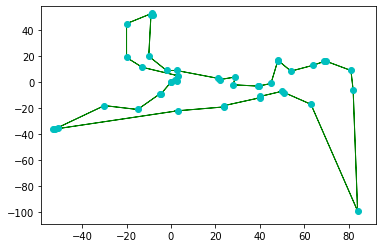

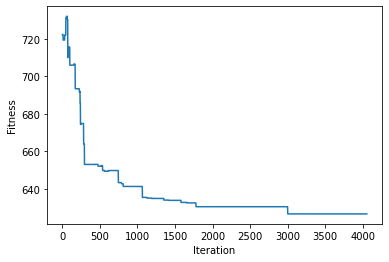

In [ ]:
import random


def read_coords(path):
    coords = []
    with open(path, "r") as f:
        for line in f.readlines():
            line = [float(x.replace("\n", "")) for x in line.split(" ")]
            coords.append(line)
    return coords


def generate_random_coords(num_nodes):
    return [[random.uniform(-1000, 1000), random.uniform(-1000, 1000)] for i in range(num_nodes)]


if __name__ == "__main__":
    coords = read_coords("/content/coord.txt")  # generate_random_coords(100)
    sa = SimAnneal(coords, stopping_iter=5000)
    sa.anneal()
    sa.visualize_routes()
    sa.plot_learning()